In [1]:
from sklearn.datasets import make_circles
from sklearn.metrics import log_loss

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
sns.set_context('talk')

In [52]:
def make_dataset(seed=42):
    data_features, data_classes = make_circles(
        n_samples=10000, 
        noise=0.1, 
        random_state=seed
    )

    df = pd.DataFrame(data_features, columns=['x', 'y'])
    df['class'] = data_classes

    return df

df = make_dataset(seed=42)
test_df = make_dataset(seed=66)

In [3]:
df.head()

,x,y,class
0,0.712108,0.284698,1
1,-0.678716,0.207274,1
2,-0.866026,0.343651,1
3,-0.517648,0.620599,1
4,0.454089,-0.890466,0


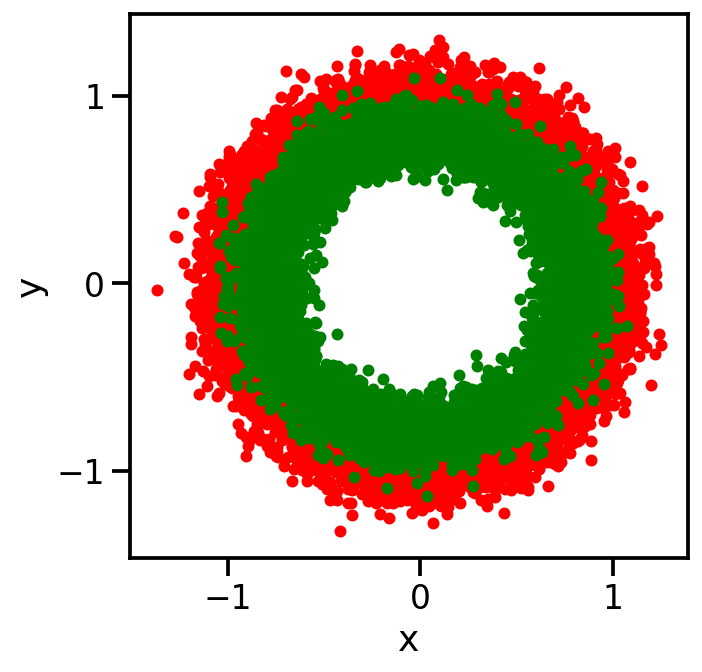

In [53]:
def plot_binary_classes(data, labels, ax=None):
    
    if ax is None:
        fig = plt.figure(figsize=[5,5])
        ax = fig.gca()
        
    data.loc[labels == 0].plot(kind='scatter', x='x', y='y', color='red', ax=ax)
    data.loc[labels == 1].plot(kind='scatter', x='x', y='y', color='green', ax=ax)
    
    plt.yticks([-1, 0, 1])
    plt.xticks([-1, 0, 1])
    
plot_binary_classes(df, df['class'])

In [5]:
from statsmodels.discrete.discrete_model import Logit

df['const'] = 1
reg = Logit(df['class'], df[['const', 'x', 'y']]).fit()

Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3


Accuracy = 0.504
Log Loss = 0.693


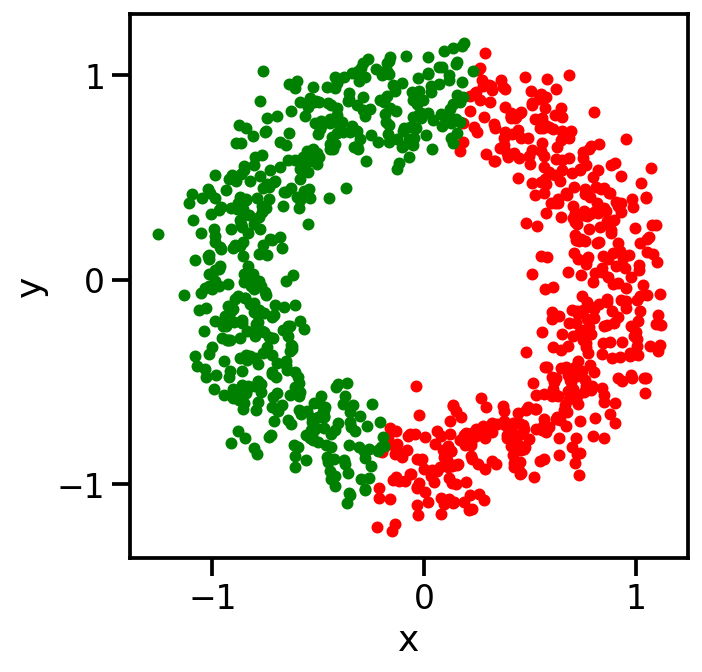

In [6]:
reg_probs = reg.predict(df[['const', 'x', 'y']])
ll = round(log_loss(df['class'], reg_probs), 3)

reg_classes = reg_probs > 0.5
plot_binary_classes(df, reg_classes)

acc = (reg_classes == df['class']).mean()
print(f'Accuracy = {acc}')
print(f'Log Loss = {ll}')

plt.show()

In [7]:
def plot_binary_distributions(series, classes):
    fig = plt.figure(figsize=[10,5])
    plt.title('Distribution of values by class')
    sns.distplot(series.loc[classes == 0], label='class = 0', color='red')
    sns.distplot(series.loc[classes == 1], label='class = 1', color='green')
    plt.legend()

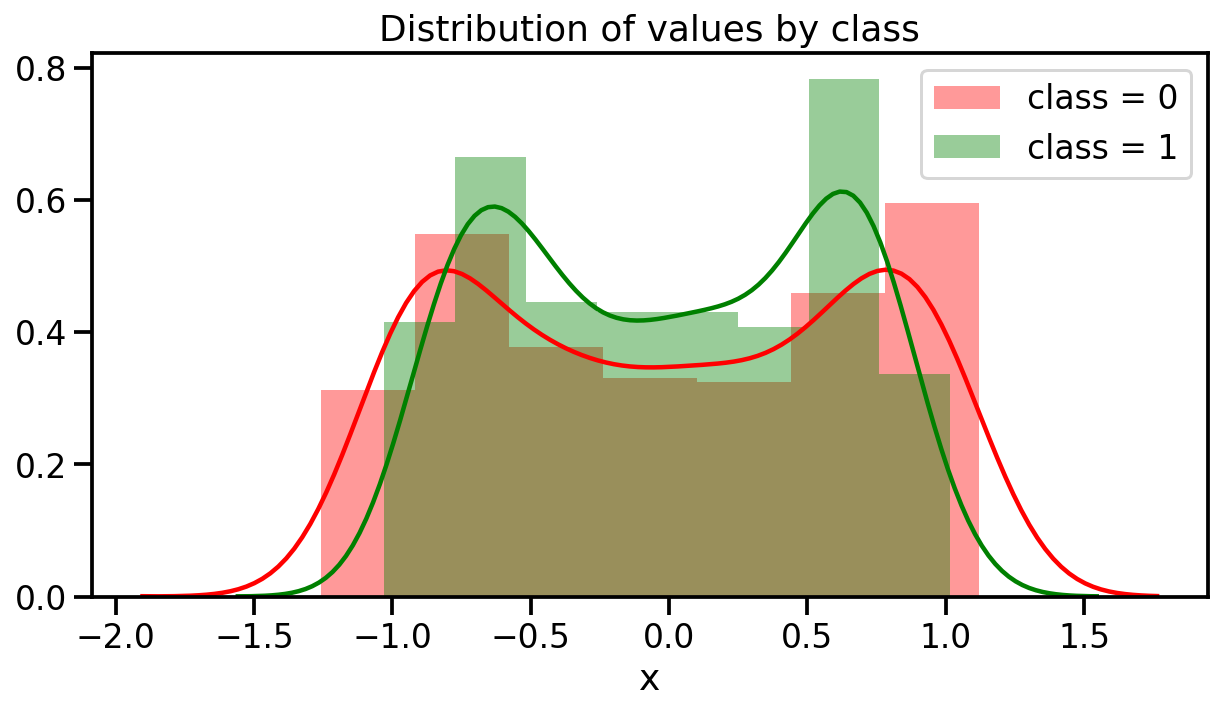

In [8]:
plot_binary_distributions(df['x'], df['class'])

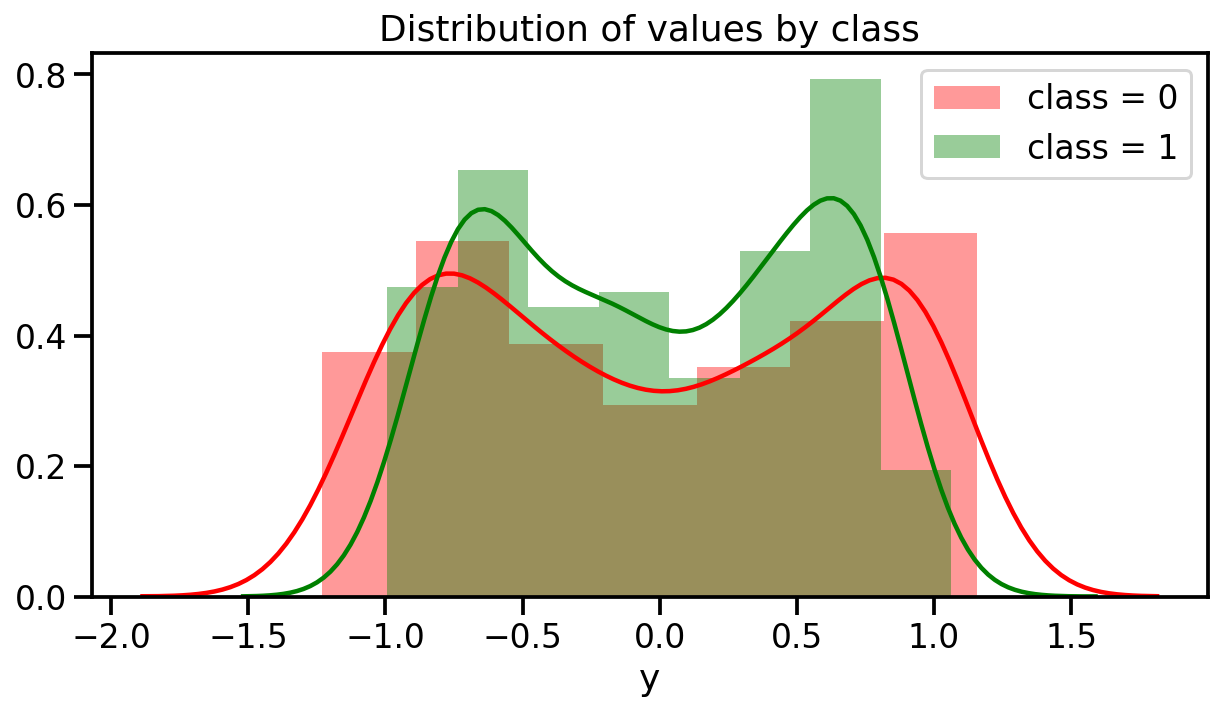

In [9]:
plot_binary_distributions(df['y'], df['class'])

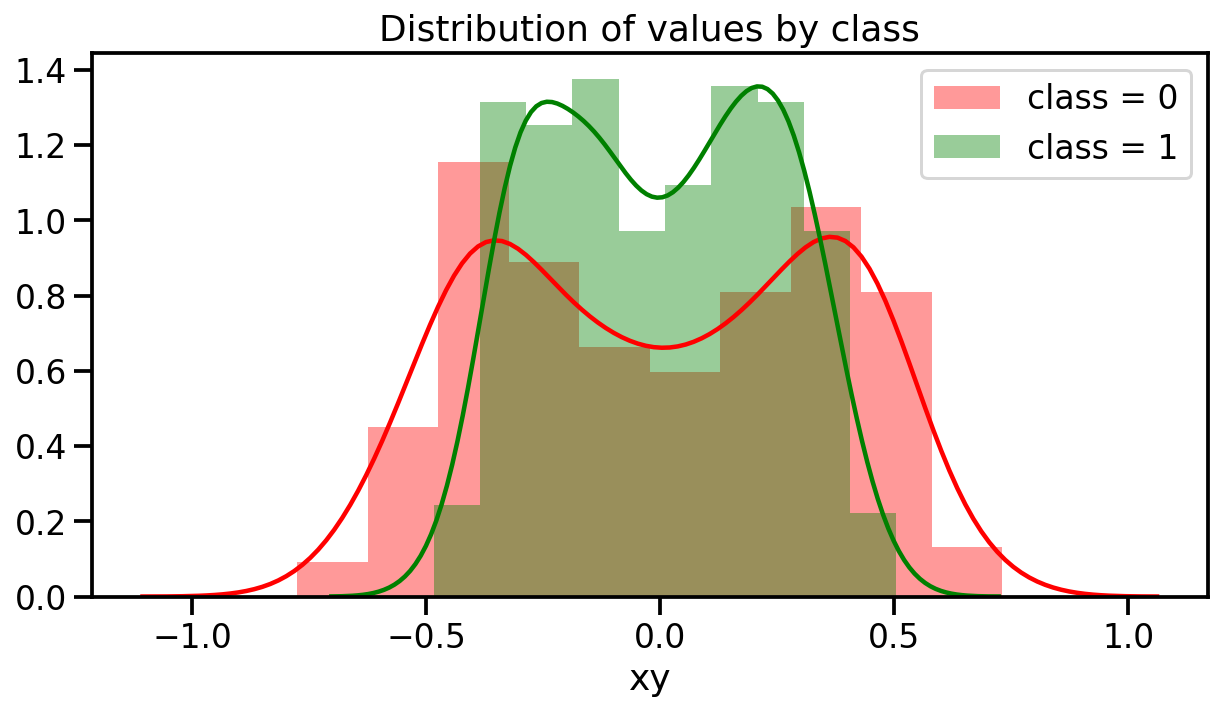

In [10]:
df['xy'] = df['x'] * df['y']
plot_binary_distributions(df['xy'], df['class'])

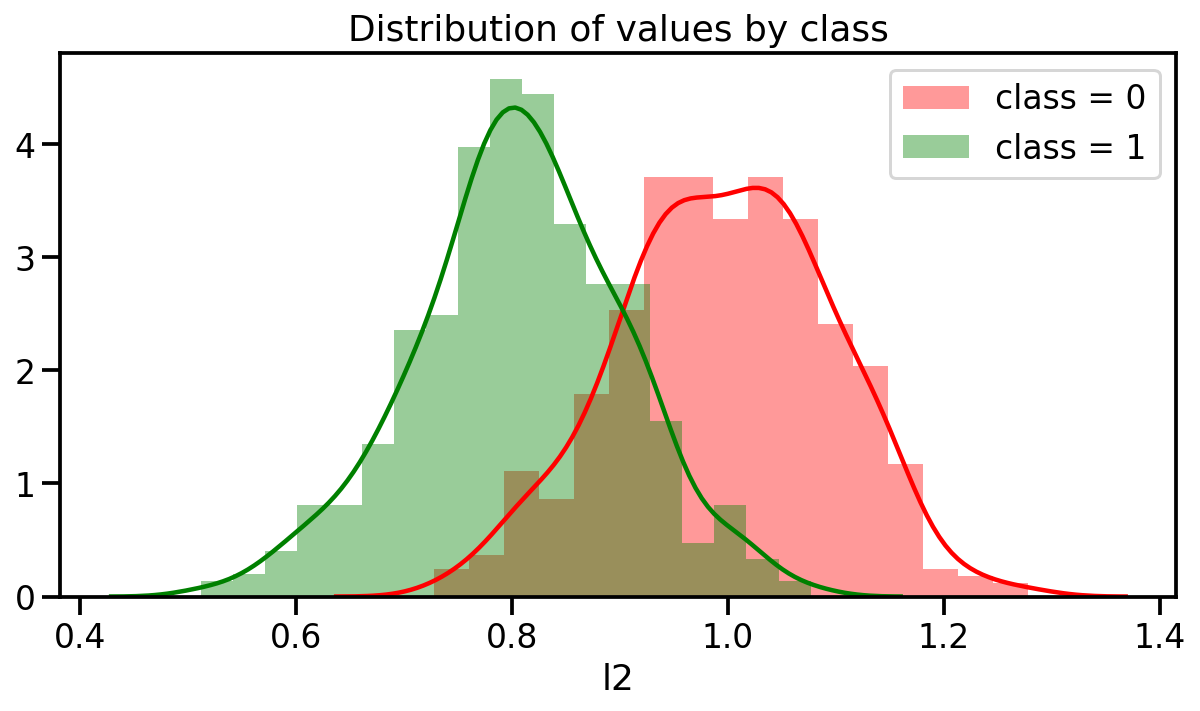

In [26]:
df['l2'] = (df['x'].pow(2) + df['y'].pow(2)).pow(1/2)
plot_binary_distributions(df['l2'], df['class'])

Optimization terminated successfully.
         Current function value: 0.370262
         Iterations 7
Accuracy = 0.83
Log Loss = 0.37


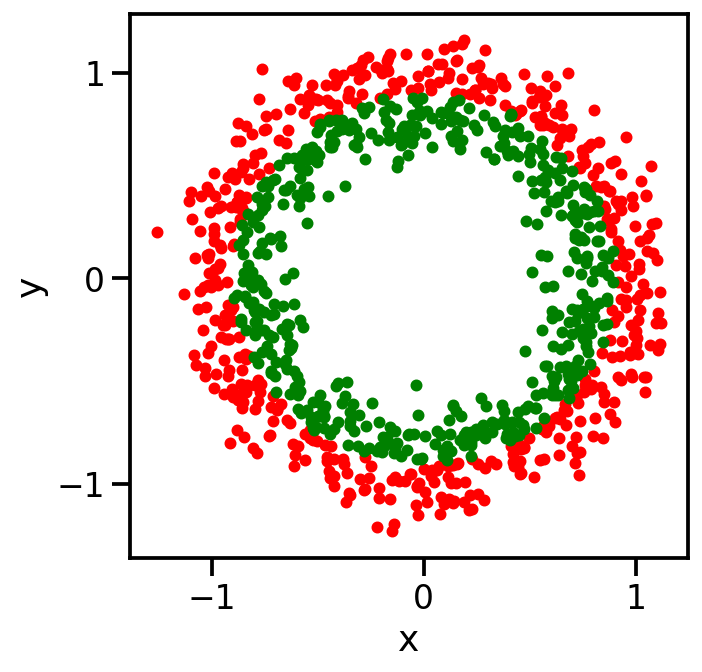

In [12]:
reg_l2_features = df[['const', 'l2']]

reg_l2 = Logit(df['class'], reg_l2_features).fit()
reg_l2_probs = reg_l2.predict(reg_l2_features)

reg_l2_classes = reg_l2_probs > 0.5
plot_binary_classes(df, reg_l2_classes)

ll = round(log_loss(df['class'], reg_l2_probs), 3)
acc = (reg_l2_classes == df['class']).mean()

print(f'Accuracy = {acc}')
print(f'Log Loss = {ll}')

plt.show()

In [8]:
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.initializers import GlorotUniform
import tensorflow as tf

In [23]:
def build_nn_classifier(kernel_seed):
    model = Sequential([
        Dense(
            units=10, 
            activation='tanh',
            kernel_initializer=GlorotUniform(seed=kernel_seed)
        ),
        Dense(
            units=1, 
            activation='sigmoid',
            kernel_initializer=GlorotUniform(seed=kernel_seed+100)
        )
    ])
    
    model.compile(Adam(lr=0.1), 'binary_crossentropy')
    
    return model


def train_nn(model, X, y, batch_seed):  
    # This seed controls reshuffling of the batches.
    np.random.seed(batch_seed)
    
    model.fit(
        np.array(X), 
        np.array(y), 
        epochs=10, 
        verbose=0
    )
    
    return model


def train_nn_classifier(X, y, seed):
    model = build_nn_classifier(kernel_seed=seed)
    train_nn(model, X, y, seed)
    return model
    

def evaluate_model(df, model, title=True):
    probs = model.predict(df[['x', 'y']]).reshape(-1)
    plot_binary_classes(df, probs > 0.5)

    ll = round(log_loss(df['class'], probs), 3)
    title_text = f'Log Loss = {ll}'
    
    if title:
        plt.title(title_text)
    else:
        print(title_text)

Log Loss = 0.438


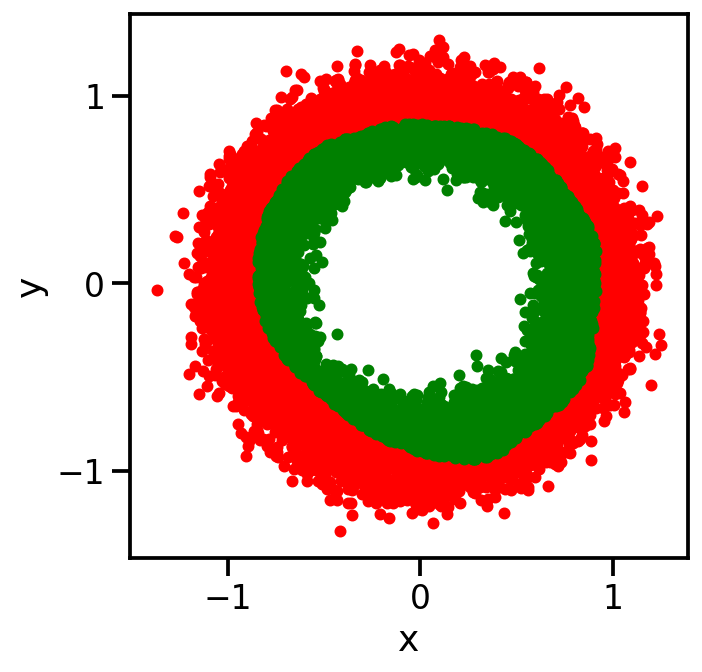

In [54]:
model = train_nn_classifier(df[['x', 'y']], df['class'], seed=42)
evaluate_model(df, model, title=False)

In [55]:
def plot_predictions_grid(df, models):
    model_probs = [
        model.predict(df[['x', 'y']]).reshape(-1)
        for model in models
    ]

    ncols = 3
    nrows = 3

    n_data = len(model_probs)
    n_cells = ncols * nrows

    idxs = np.linspace(0, n_data-1, n_cells)
    idxs = idxs.round().astype(int)

    fig = plt.figure(figsize=[3*ncols, 3*nrows])
    # fig.subplots_adjust(hspace=0, wspace=0)

    for cell_id, data_id in enumerate(idxs):
        ax = plt.subplot(nrows, ncols, cell_id+1)

        ll = round(log_loss(df['class'], model_probs[data_id]), 3)
        plt.title(f'Log Loss = {ll}')

        plot_binary_classes(df, model_probs[data_id] > 0.5, ax=ax)

        plt.xticks([])
        plt.yticks([])
        plt.xlabel('')
        plt.ylabel('')

    plt.tight_layout()
    

def predict_mean_ensemble(df, models):
    probs = np.array([
        model.predict(df[['x', 'y']]).reshape(-1) 
        for model in models
    ])
    
    probs = probs.mean(axis=0)
    
    return probs


def evaluate_probs(df, probs):
    plot_binary_classes(df, probs > 0.5)
    
    ll = round(log_loss(df['class'], probs), 3)    
    print(f'Log Loss = {ll}')
    

def plot_distribution_log_loss(df, models):
    plt.figure(figsize=[10, 5])
    plt.title('Distribution of Log Loss by Ensemble Member')

    lls = [
        log_loss(df['class'], model.predict(df[['x', 'y']]).reshape(-1)) 
        for model in models
    ]
    sns.distplot(lls)
    
    plt.axvline(np.mean(lls), color='red', label='mean of log loss')

    ensemble_ll = log_loss(df['class'], predict_mean_ensemble(df, models))
    plt.axvline(ensemble_ll, color='green', label='log loss of mean')

    plt.legend()
    plt.show()

In [56]:
import random

np.random.seed(42)
noise_seeds = np.random.randint(0, 1e6, size=5)

noise_models = [
    train_nn_classifier(df[['x', 'y']], df['class'], seed=seed) 
    for seed in noise_seeds
]

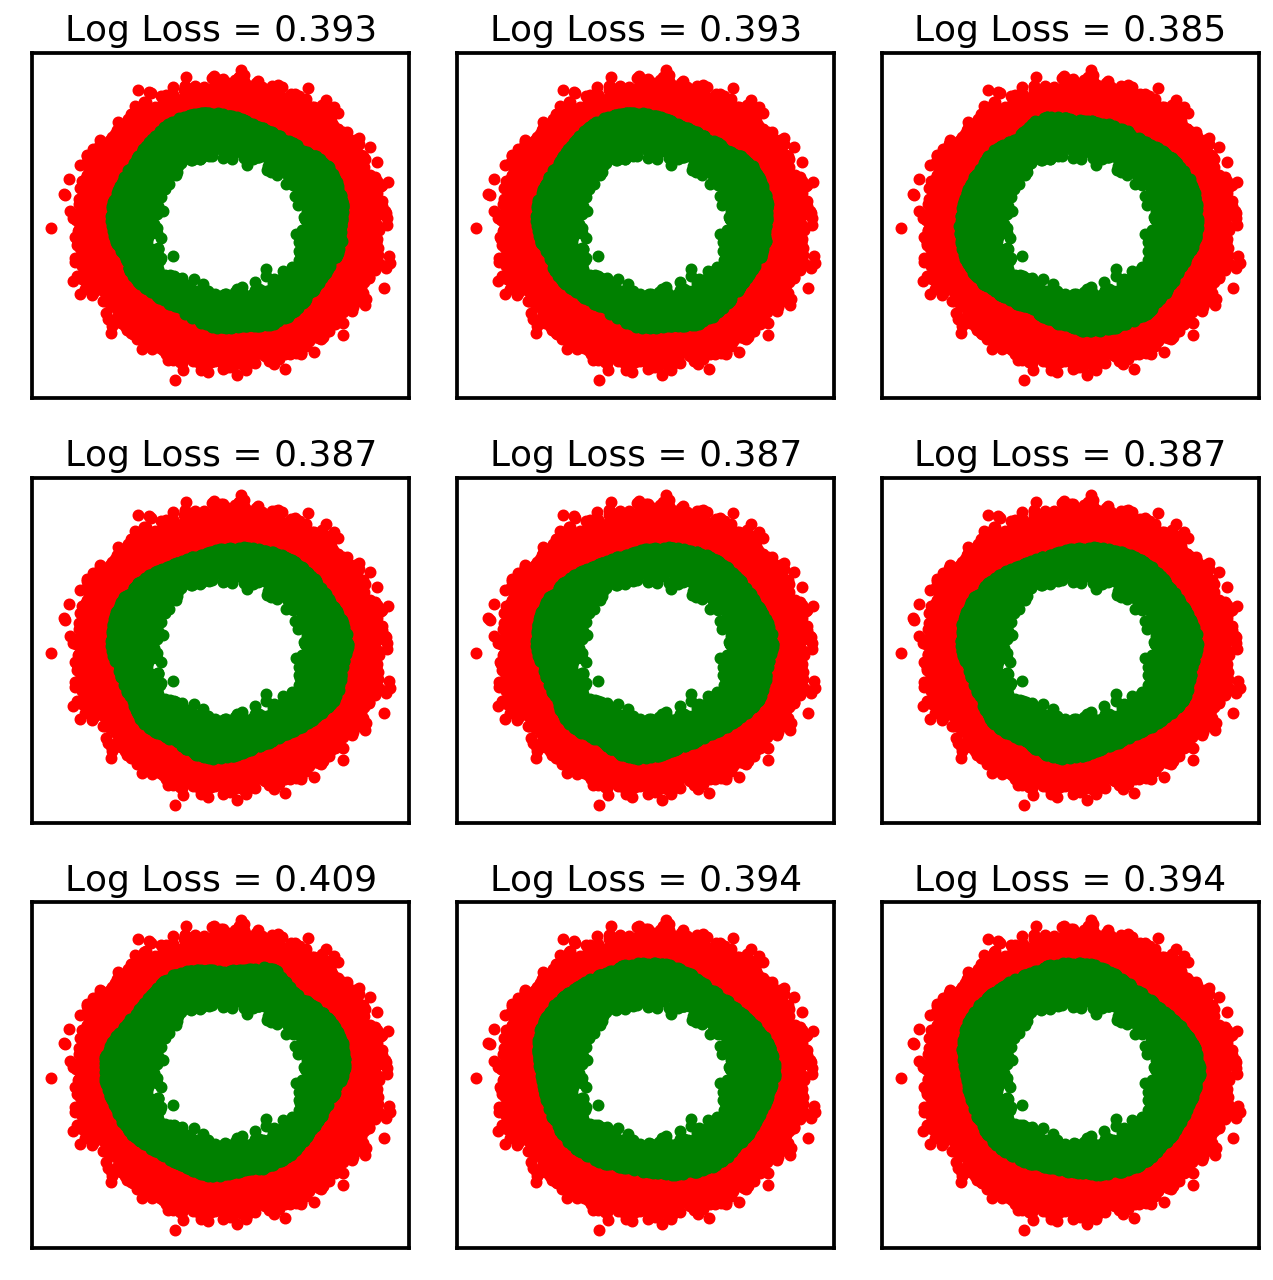

In [57]:
plot_predictions_grid(df, noise_models)

Log Loss = 0.375


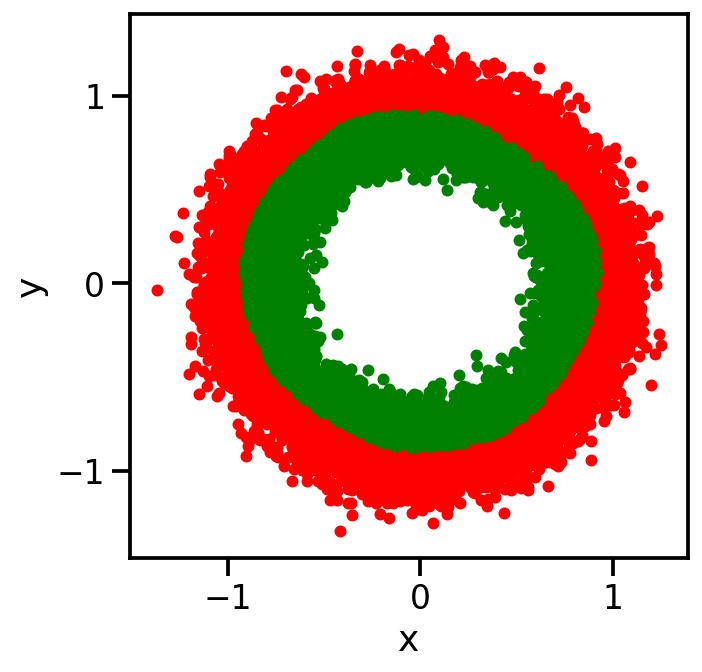

In [58]:
noise_probs = predict_mean_ensemble(df, noise_models)
evaluate_probs(df, noise_probs)

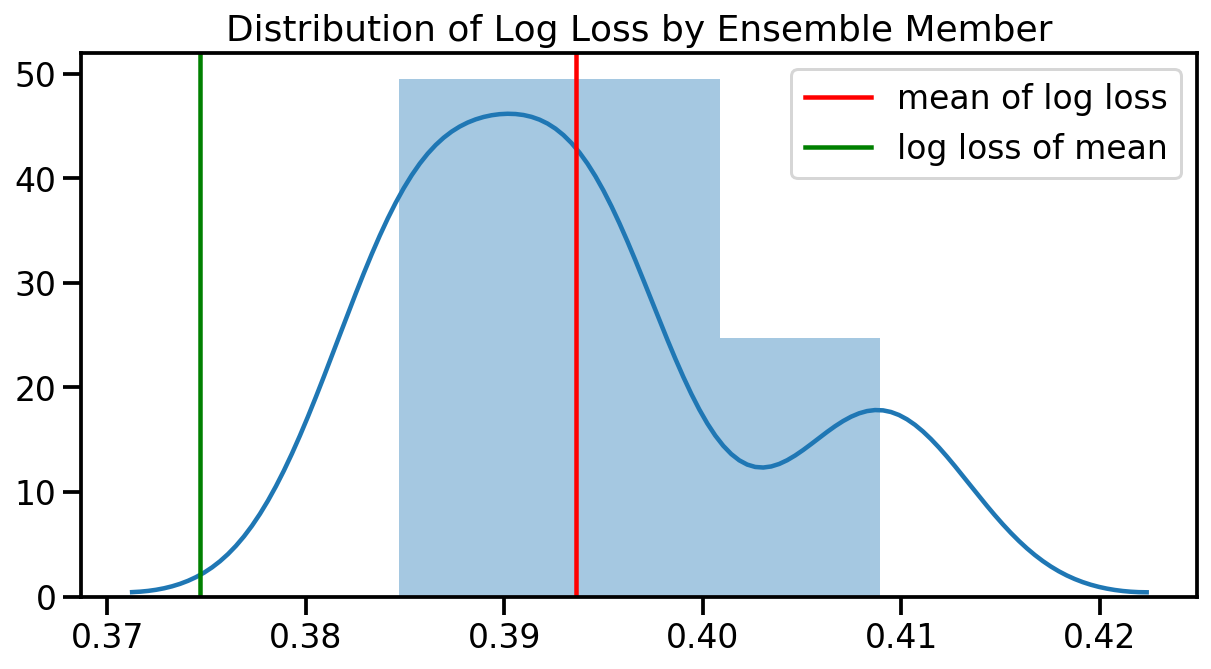

In [60]:
plot_distribution_log_loss(df, noise_models)

In [29]:
bag_size = df.shape[0]
bag_seeds = np.random.randint(0, 1e6, size=20)
bags = [df.sample(n=bag_size, random_state=seed) for seed in bag_seeds]
bag_models = [
    train_nn_classifier(bag[['x', 'y']], bag['class'], seed=42) 
    for bag in bags
]

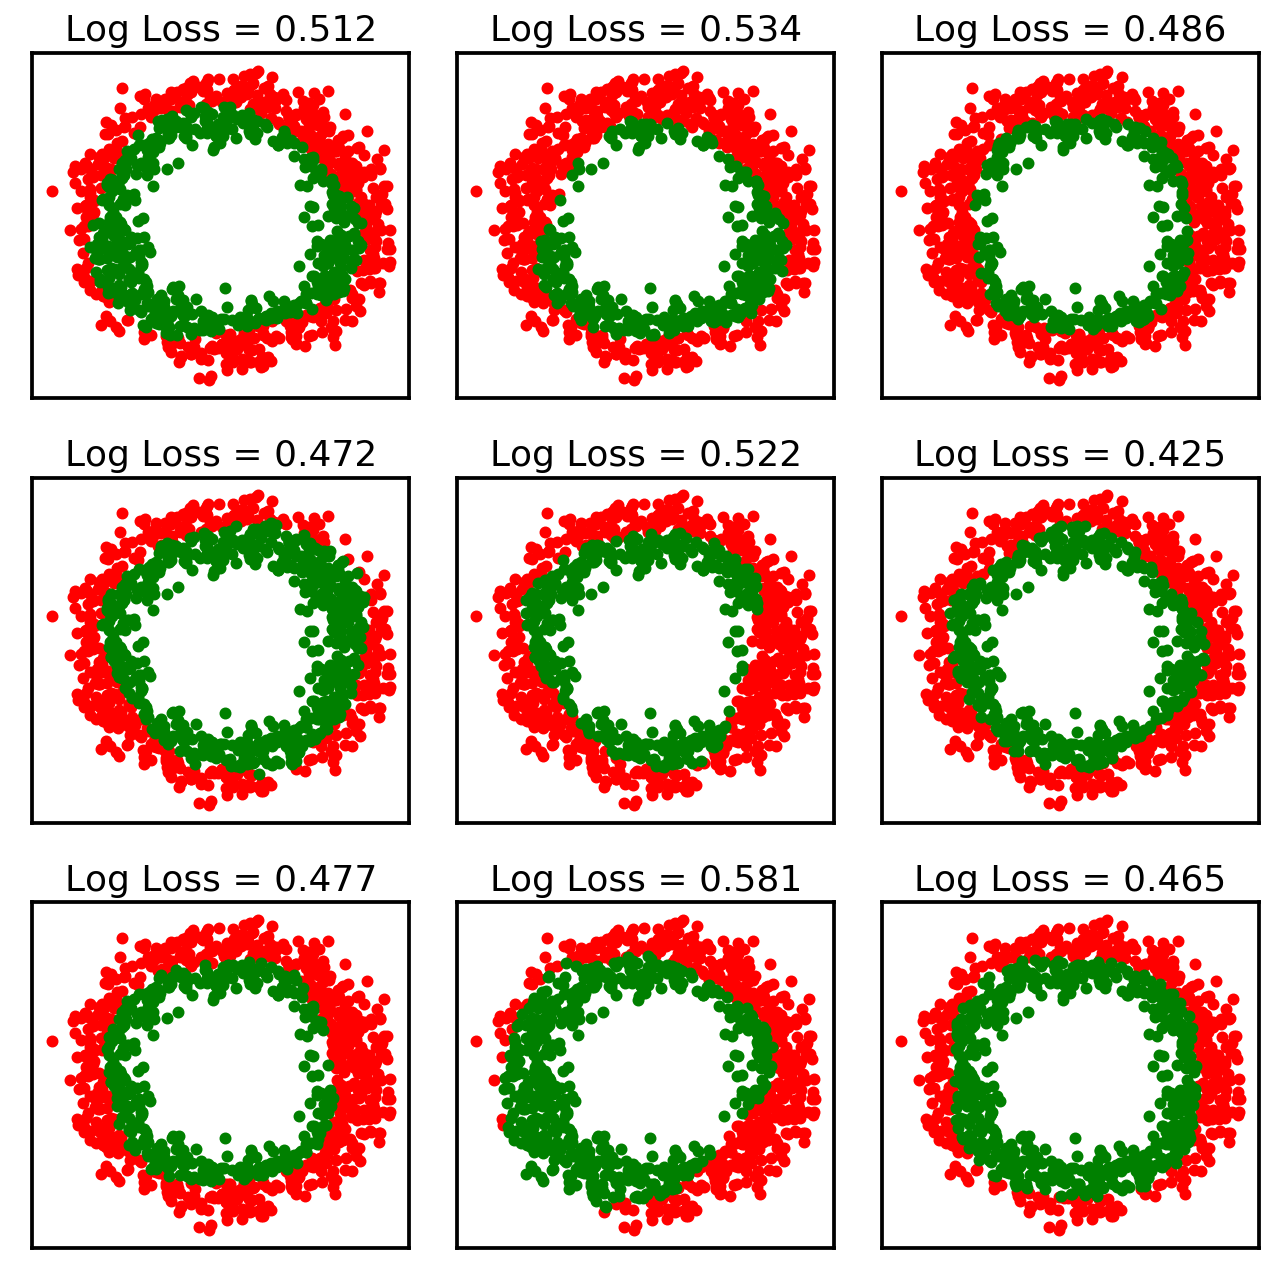

In [30]:
plot_predictions_grid(df, bag_models)

Log Loss = 0.461


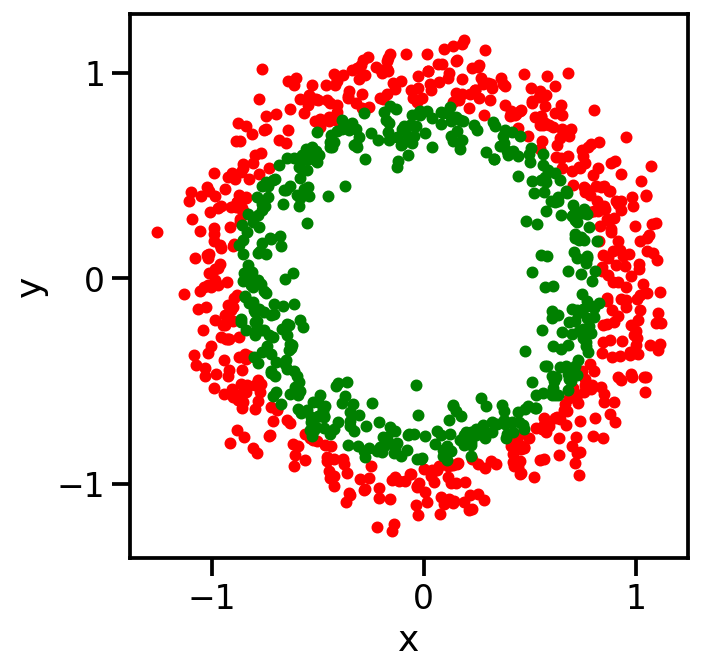

In [31]:
bag_probs = predict_mean_ensemble(df, bag_models)
evaluate_probs(df, bag_probs)

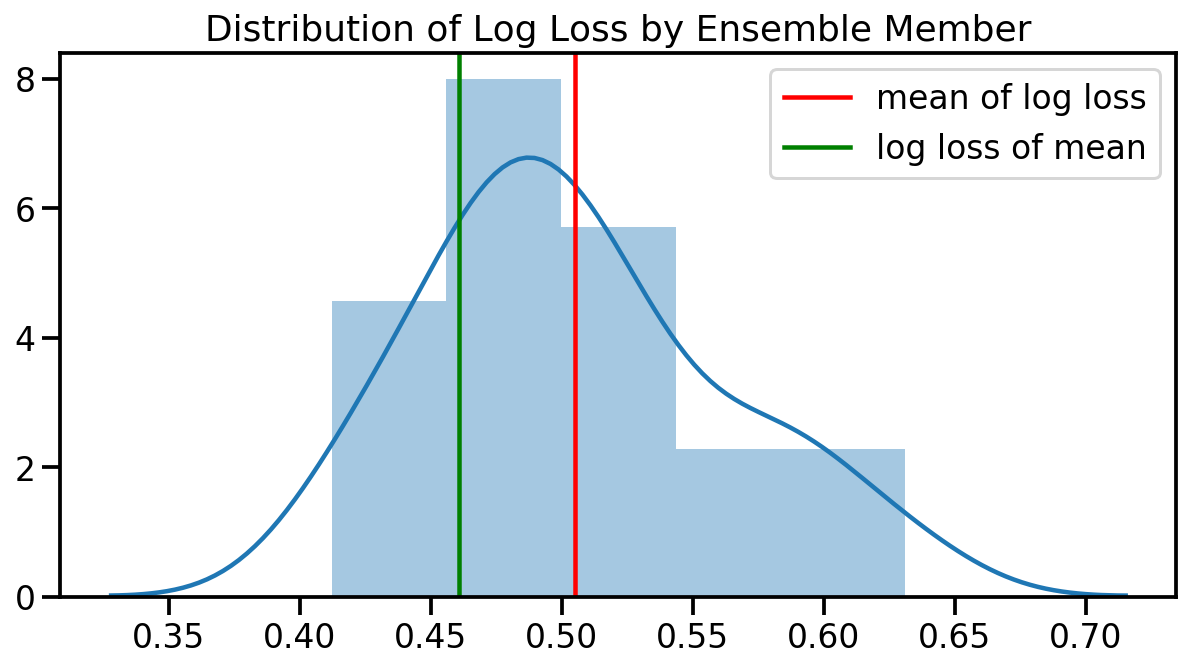

In [32]:
plot_distribution_log_loss(df, bag_models)